In [101]:
import numpy as np
import matplotlib.pyplot as plt

# ----- make nice figures -----
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
from cycler import cycler
COLORS = ['#F00D2C', '#242482', '#0071BE', '#4E8F00', '#553C67', '#DA5319']
default_cycler = cycler(color=COLORS)
plt.rc('axes', prop_cycle=default_cycler) 
# -----------------------------

# Data requirements in 1 dimension is misleading

If we only have 1 material descriptor, i.e. if $x$ is 1 dimensional, then the data requirements to fit most reasonable functions is actually quite low. To put it another way, for a given set of data, we can actually fit a fairly high degree polynomial, which is often enough for most settings, even if the truth isn't polynomial.

Below, we generate noisy data from the function

$$y = \sin(5x) - 0.3\sin(20x) + 2.4x,$$

In [ ]:
x = np.random.uniform(0, 1, 60)
y = np.sin(5*x) - 0.3*np.sin(20*x) + 2.4*x  + np.random.normal(0, 0.1, len(x))

plt.scatter(x, y)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

Assuming this is all training data (i.e. we have already removed the data needed for validation and testing), then we can fit anywhere between a degree 5 to a degree 29 polynomial and stay within the $2-10\times$ rule of thumb between data and number of basis functions. Let's try to fit it to a 15 degree polynomial.

In [ ]:
d = 15

# Solve least squares solution
Phi = np.vander(x, d+1)
theta_ls = np.linalg.lstsq(Phi, y)[0]

# plot model and the data
x_plot = np.linspace(0, 1, 100)
Phi_plot = np.vander(x_plot, d+1)
y_plot = Phi_plot @ theta_ls
plt.plot(x_plot, y_plot, color = COLORS[1])
plt.scatter(x, y)
plt.legend(['Model', 'Data'])

plt.grid()
plt.xlabel('x')
plt.ylabel('y')


We get a pretty good fit dispite the function not actually being a degree 15 polynomial. In fact, we can plot the noiseless truth as well.

In [ ]:
y_truth = np.sin(5*x_plot) - 0.3*np.sin(20*x_plot) + 2.4*x_plot
plt.plot(x_plot, y_truth, color = COLORS[3])
plt.plot(x_plot, y_plot, color = COLORS[1])
plt.scatter(x, y)
plt.legend(['Truth', 'Model', 'Data'])

plt.grid()
plt.xlabel('x')
plt.ylabel('y')


# Plotting the number of monomials of a certain degree.

To see how this is misleading, let us instead consider how many monomials in $k$ variables of degree at most $n$. This number will be the size of the basis function set, and ultimately determine our data requirements if we wish to use the monomial basis and still follow the $2-10\times$ rule of thumb.

The number of such monomials is given by the combinatorial formula

$$\binom{n + k}{n} - 1.$$

We plot this for different values of $n$ and $k$.

In [ ]:
from scipy.special import binom

n = 4
k = np.arange(1, 15).astype('int')
num_monoms = binom(n+k, n) - 1

plt.plot(k, num_monoms)
plt.grid()
plt.xlabel('Number of descriptors (k)')
plt.ylabel('Number of monomials')
plt.title('n = %d' % n)

This combinatorial growth in our data requirements as we increase k is a manifestation of the **Curse of Dimensionality**, which in broad terms is just the observation that problems quickly become difficult as their dimensionaltiy increases.

# Least squares when we don't have enough data

In high dimensions, therefore, we are often in a data-deficient setting. Below, we consider the case where we only have 5 data points, and we're trying to fit to a degree 20 polynomial. This is bound to fail.

In [ ]:
x = np.random.uniform(0, 1, 5)
y = 1 + 10*x - 100*x**2 + 1000*x**3 + np.random.normal(0, 0.2, len(x))
Phi = np.vander(x, 20, increasing=True)
print(Phi.shape)

Recall that if we were to try to find the least-squares solution to this, we'd have to solve the normal equations

$$\Phi^T \Phi \vec \theta = \Phi^T \vec y$$

In this setting, the matrix on the left-hand side $A = \Phi^T\Phi$ is **rank deficient,$$ which means a unique solution to the above is impossible. Below we see that despite being a $20\times 20$ matrix, its rank is only $5$ (this is the most it can be since we had 5 data points).


In [ ]:
A = Phi.T@Phi
rank = np.linalg.matrix_rank(A)

print("Size of A = " + str(A.shape))
print("Rank of A = " + str(rank))

In fact, there are an infinite number of solutions to this system. I do not know which one the `numpy.linalg.lstsq` returns. Regardless, we can try to visualize the solution, and in particular the size of its entries.

In [ ]:
theta_ls = np.linalg.lstsq(Phi, y, rcond=None)[0]
plt.plot(theta_ls, marker = 'o' )
plt.grid()
plt.xlabel('i')
plt.ylabel('theta_i')

We see that the size of some of its entries can get really large. This is indicative of overfitting.

# Regularization

Motivated by above, we would like to restrict the space of least-square solutions $\vec \theta$, which minimize the least-squares loss function

$$ \large L_\text{LS}(\vec \theta) = \| \vec y - \Phi \vec \theta \|^2_2,$$

where $\Phi$ is the $m \times n$ design matrix, $\vec y$ is the observation vector and $\vec \theta$ is the vector of coefficients we are trying to solve for. The least-squares solution is the $\vec \theta$ that minimizes this:

$$ \large \vec\theta_\text{LS} = \arg\min L_\text{LS}(\vec \theta).$$

Two regularization techniques:
* L1 regularization (aka **Lasso**):
$$\large L_\text{Lasso}(\vec \theta) = \| \vec y - \Phi \vec \theta \|_2^2 + \lambda \| \vec \theta\|_1.\\ $$

* L2 regularization (aka **Ridge (or Tikhonov) Regularization**):
$$\large L_\text{Ridge}(\vec \theta) = \| \vec y - \Phi \vec \theta \|_2 ^2 + \lambda \| \vec \theta\|_2^2 $$

## Ridge Regression

Below, we'll plot some noisy data and the true function it came from.

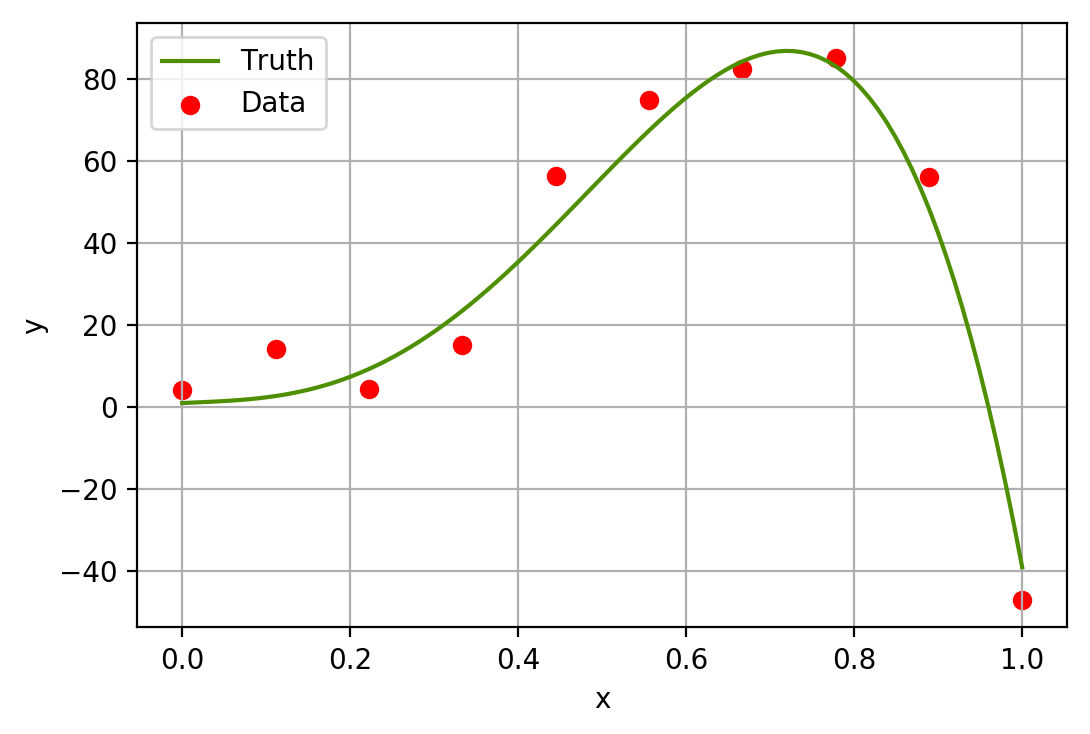

In [103]:
def f(x):
    return 1 + 10*x - 50*x**2 +1000*x**3 - 1000*x**4

x_data = np.linspace(0, 1, 10)
y_data = f(x_data) + np.random.normal(0, 10, len(x_data))
plt.scatter(x_data, y_data, color='r')

x_plot = np.linspace(0, 1, 100)
y_truth = f(x_plot)
plt.plot(x_plot, y_truth, color = COLORS[3])

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(['Truth', 'Data'])

Now we'll try to fit a degree 10 polynomial, which is too large of a model for our limited set of data.

In [104]:
Phi = np.vander(x, 11, increasing=True)

# Print out rank for our information
rank = np.linalg.matrix_rank(Phi)
num_cols = Phi.shape[1]
print("Phi has rank = " + str(rank))
print("n = " + str(num_cols))

# Get least squares solution
theta_ls = np.linalg.lstsq(Phi, y_obs, rcond=None)[0]

Phi has rank = 10
n = 11


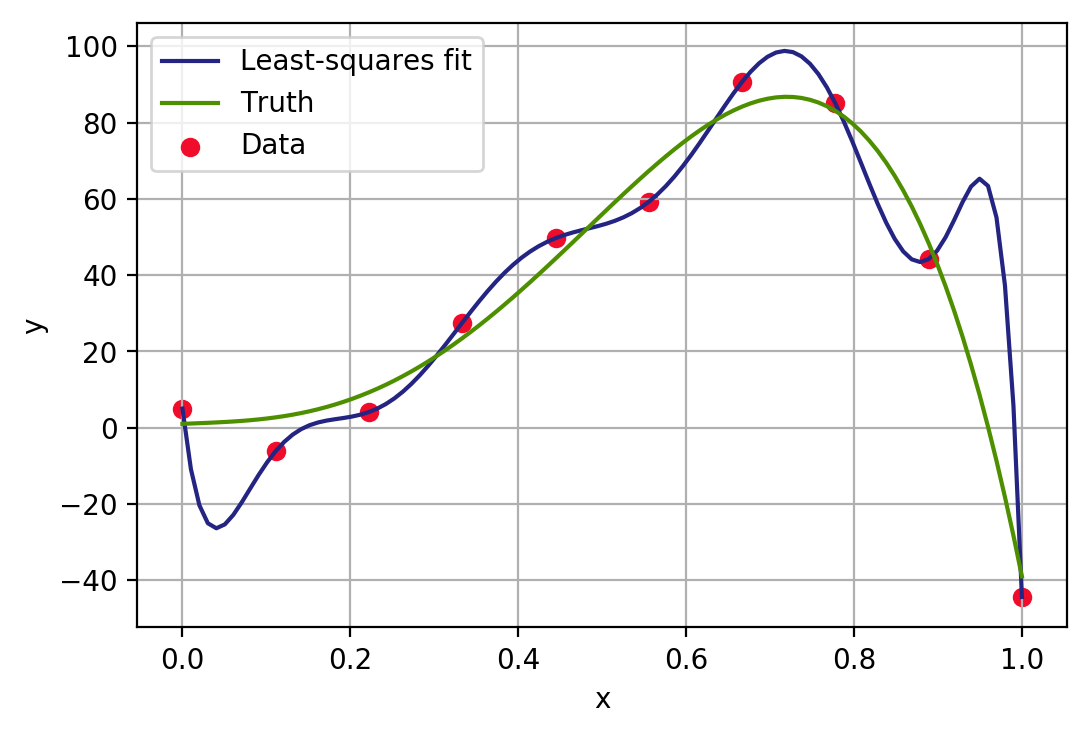

In [105]:
# evaluate and plot the model
Phi_plot = np.vander(x_plot, 11, increasing=True)
y_model = Phi_plot @ theta_ls
plt.plot(x_plot, y_model, color = COLORS[1])

# Also plot the truth
plt.plot(x_plot, y_truth,  color = COLORS[3])

# and plot the data
plt.scatter(x, y_obs,)

plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Least-squares fit', 'Truth',  'Data'])

As we feared, it overfit the data. Let's look at the entries of the least-square solution.

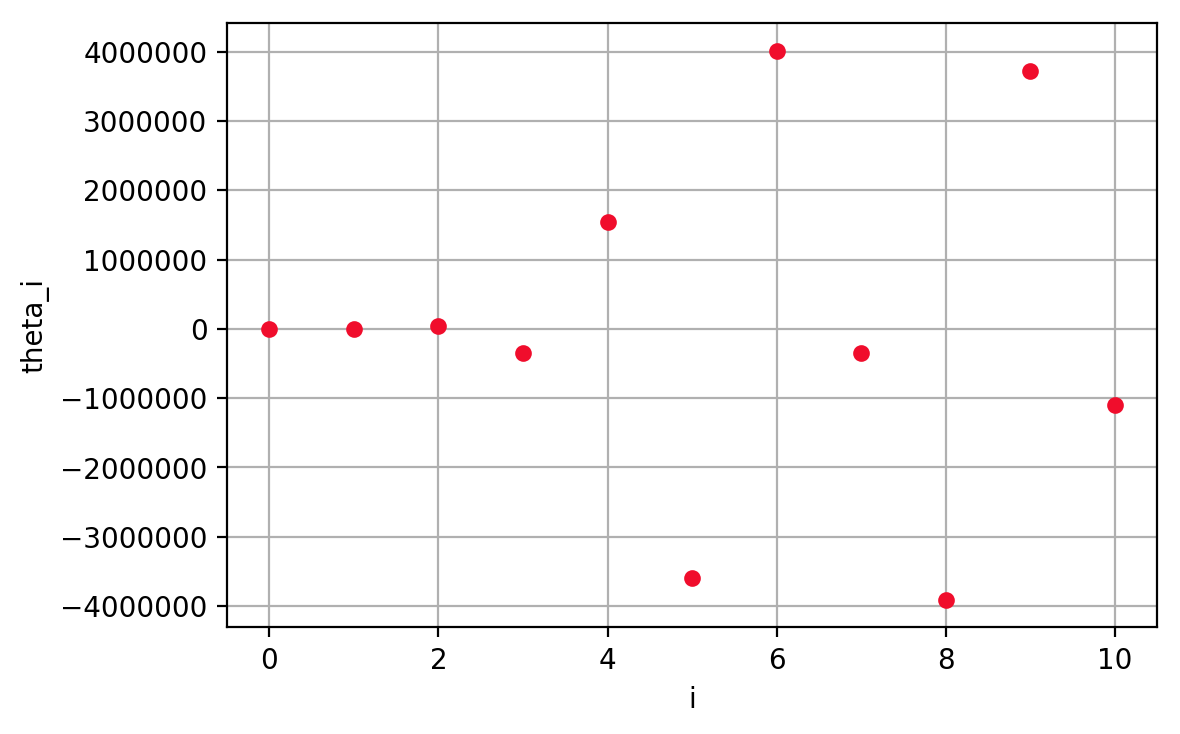

In [106]:
# What theta values do we get?
plt.plot(theta_ls, linewidth=0, marker='o', markersize=5)
plt.xlabel('i')
plt.ylabel('theta_i')
plt.grid()

We would like to control or penalize large values of theta to avoid this type of behavior. So instead of minimizing least squares loss, we'll introduce a penalty term for large coefficient values:

$$\large L_\text{Ridge}(\vec \theta) = \| \vec y - \Phi \vec \theta \|_2 ^2 + \lambda \| \vec \theta\|_2^2 $$

We'll use the library: `sklearn.linear_model.Ridge` for now. 

In [107]:
from sklearn.linear_model import Ridge

# 1. set up model. Here alpha is what we've been calling lambda above
ridge_model = Ridge(alpha = 1.0)

# 2. Fit the model
ridge_model.fit(Phi, y_data)

# 3. Get coefficients
theta_ridge = ridge_model.coef_

If we plot the ridge regression solution, we see that the values are much better.

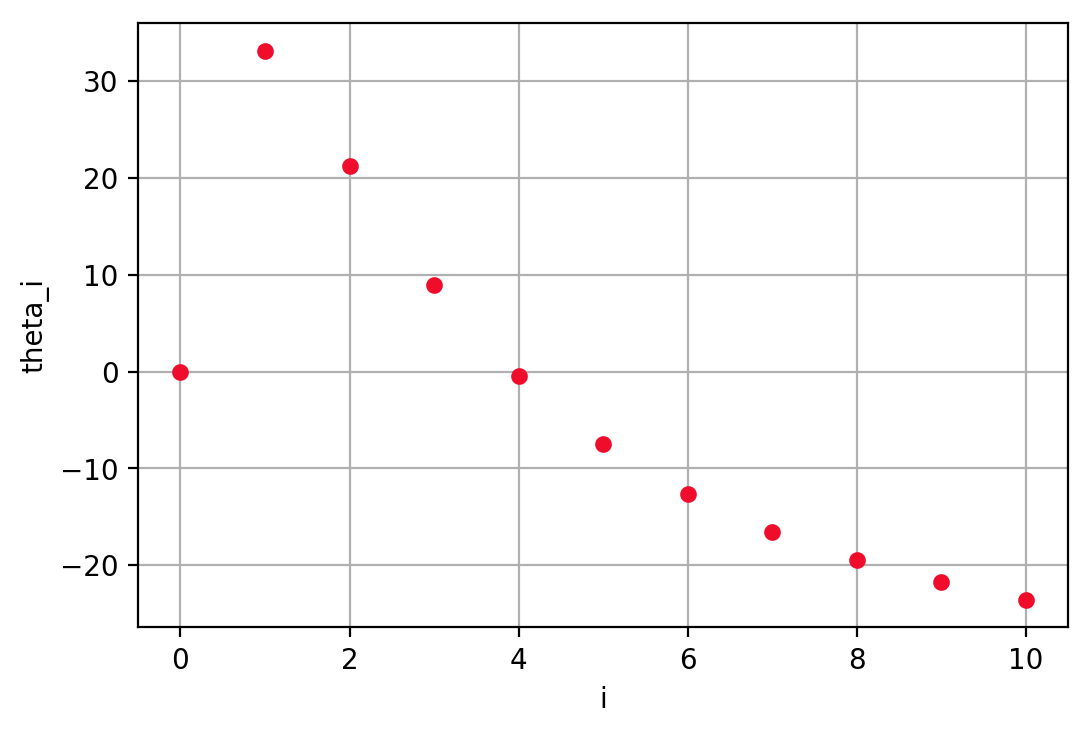

In [108]:
plt.plot(theta_ridge, linewidth=0, marker='o', markersize=5)
plt.xlabel('i')
plt.ylabel('theta_i')
plt.grid()

Let's plot the model vs. truth and data again to see our fit.

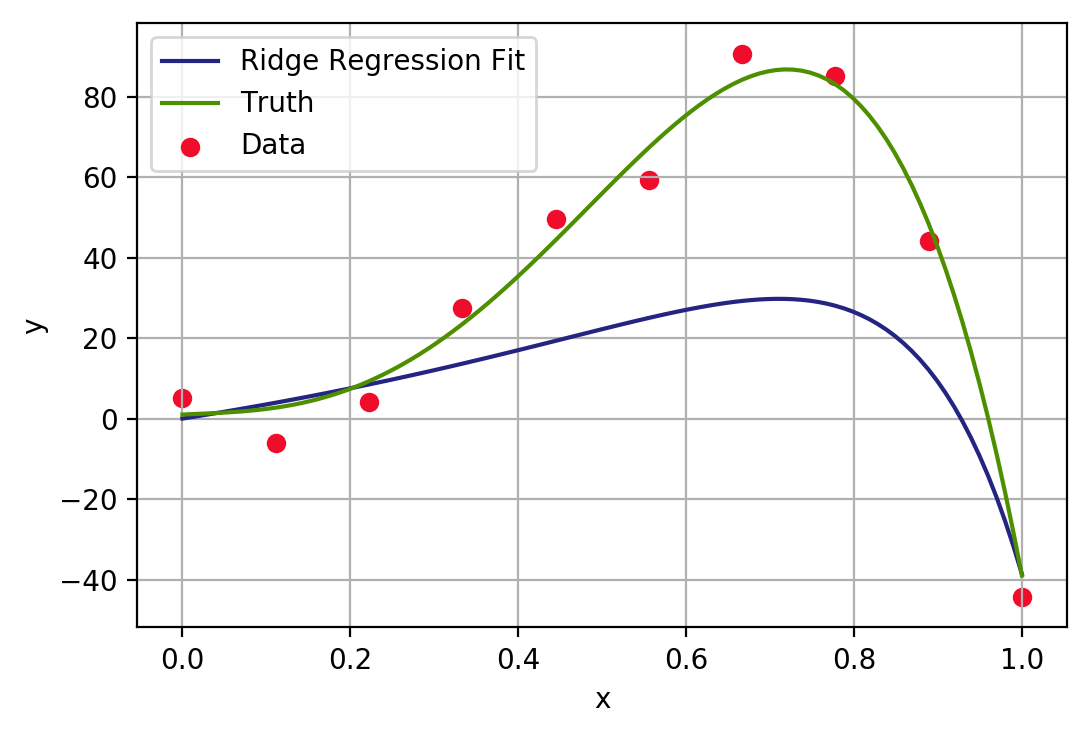

In [109]:
y_model = Phi_plot @ theta_ridge
plt.plot(x_plot, y_model, color = COLORS[1])

# Also plot the truth
plt.plot(x_plot, y_truth,  color = COLORS[3])

# and plot the data
plt.scatter(x, y_obs,)

plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Ridge Regression Fit', 'Truth',  'Data'])

It's not that great. We have a hyperparameter to play around with, the $\lambda$ regularization constant. Below, we'll try a different value (in `scikit-learn` this parameter is called `alpha`).

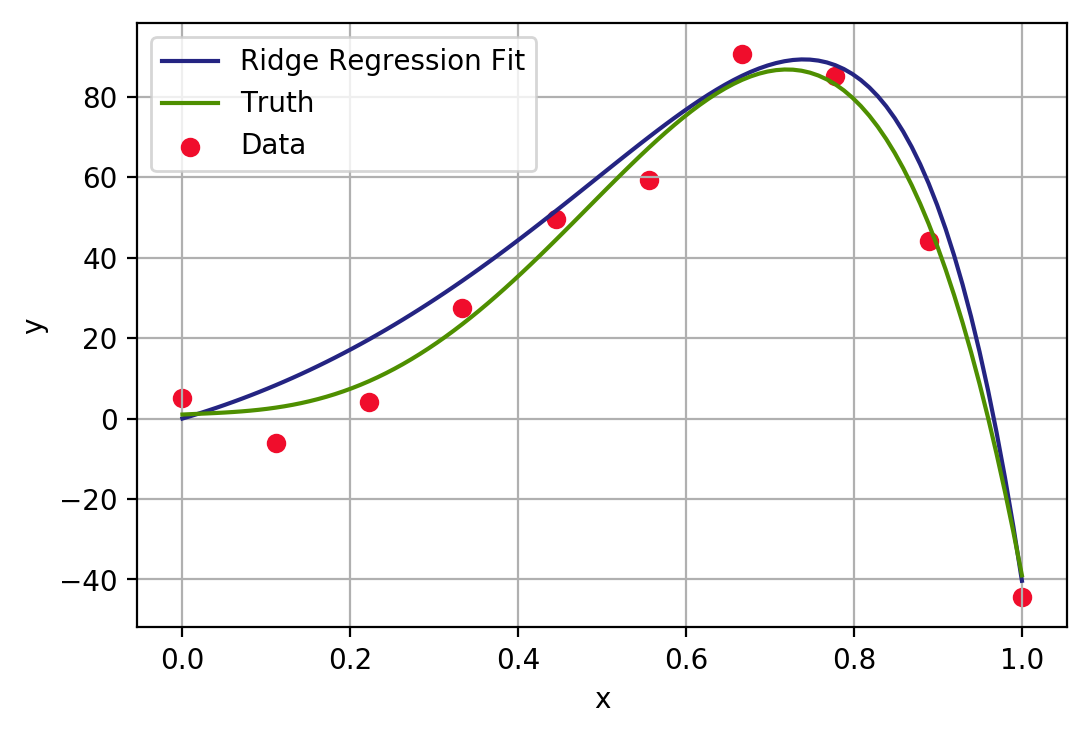

In [110]:
# Let's try lowering penality.
ridge_model = Ridge(alpha = 0.01)
ridge_model.fit(Phi, y_obs)
theta_ridge = ridge_model.coef_

# plot model
y_model = Phi_plot @ theta_ridge
plt.plot(x_plot, y_model, color = COLORS[1])

# Also plot the truth
plt.plot(x_plot, y_truth,  color = COLORS[3])

# and plot the data
plt.scatter(x, y_obs,)

plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Ridge Regression Fit', 'Truth',  'Data'])

Better, but maybe there's a better value for $\lambda$ that we haven't tried out. Being a hyperparameter, $\lambda$ is determined by validation, just like how the number of basis functions $n$ was determined by validation in a past example. Luckily, `scikit-learn` has this functionality built in in the `RidgeCV` class, which uses cross-validation to pick the best $\lambda$.

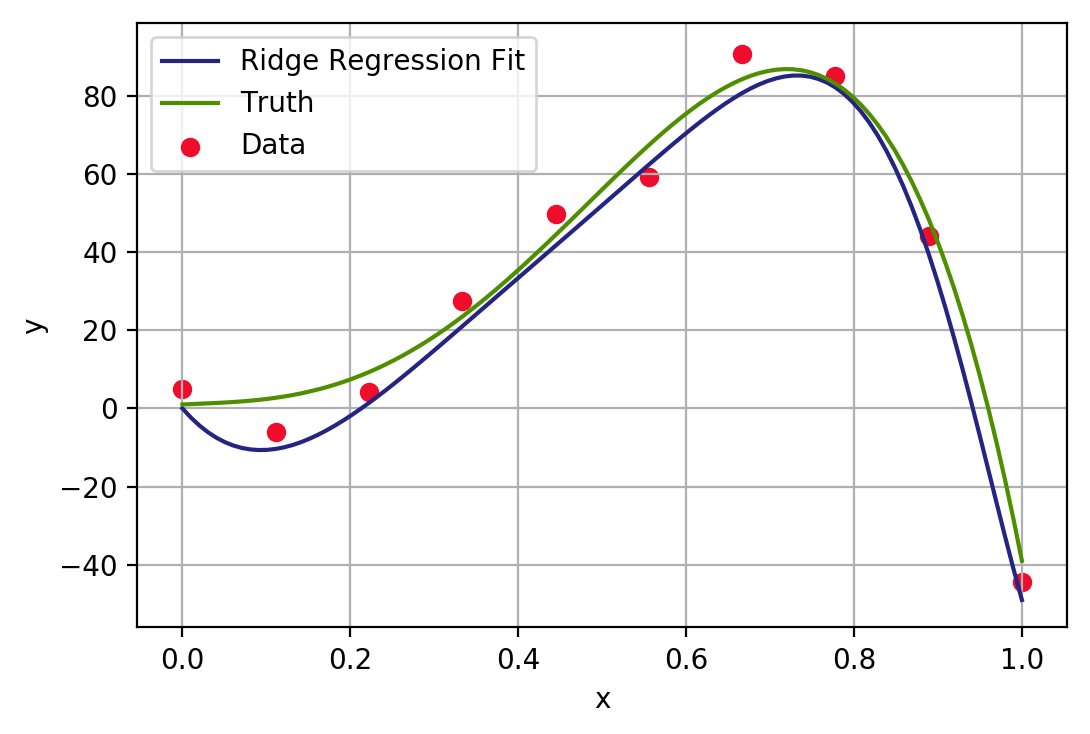

In [111]:
from sklearn.linear_model import RidgeCV

# Let's try lowering penality.
ridge_model = RidgeCV(alphas = np.logspace(-6, 4))
ridge_model.fit(Phi, y_obs)
theta_ridge = ridge_model.coef_

# plot model
y_model = Phi_plot @ theta_ridge
plt.plot(x_plot, y_model, color = COLORS[1])

# Also plot the truth
plt.plot(x_plot, y_truth,  color = COLORS[3])

# and plot the data
plt.scatter(x, y_obs,)

plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Ridge Regression Fit', 'Truth',  'Data'])

## Lasso

As discussed in the slides, L1 regularization (Lasso) takes a slightly different approach. It is used to identify **sparse** solutions - $\vec \theta$ values where most entries are 0. In this sense, this technique is good for **model selection**, wherein we have a large library of potentially relevant basis function/models, but we know the data represents a process in which only a small number of them are involved.

Below, we'll consider a sinusoidal function with modes $\sin(\omega_i t)$, where the frequencies $\omega_i$ can be one $\left\{1, 2, ..., 100\right\}$, but we may know that not all of these frequencies show up. For example, the true function could be

$$ f(x) = 0.5 \sin(x) + 0.2\sin(33x) + 0.2\sin(75x).$$

Below we'll plot some noisy data we get from this truth.

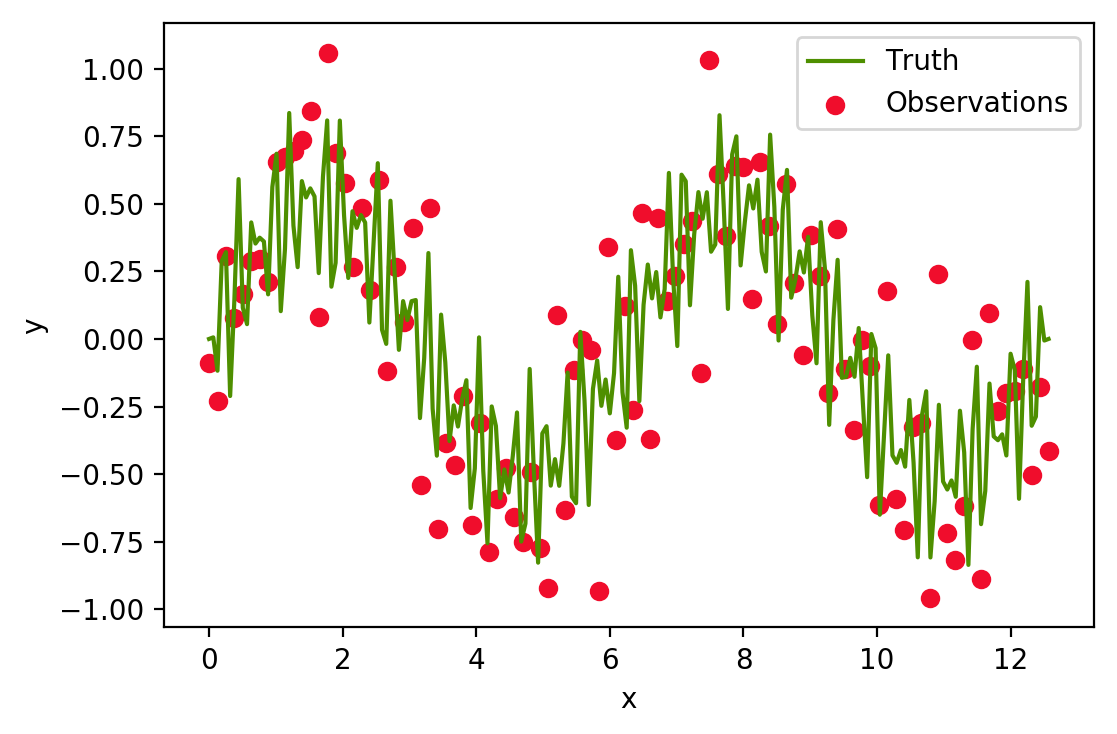

In [112]:
# The true function
def f(x):
    return 0.5*np.sin(x) + 0.2*np.sin(33.0*x) + 0.2*np.sin(75.0*x)

# generate some data
x_data = np.linspace(0, 4*np.pi, 100)
y_data = f(x_data) + np.random.normal(0, 0.2, len(x_data))


# generate truth over a more refined set just for plotting purposes
x_plot = np.linspace(0, 4*np.pi, 200)
y_plot = f(x_plot)

# Plot truth and noisy observations
plt.plot(x_plot, y_plot, color = COLORS[3])
plt.scatter(x_data, y_data)

plt.xlabel('x')
plt.ylabel('y')

plt.legend(['Truth', 'Observations'])

We would like to discover which are the relevant modes from the noisy data. We'll do this with Lasso, assuming the model

$$ y = \theta_1 \sin(x) + \theta_2 \sin(2x) + ... + \theta_{200}\sin(200x).$$

Before, when we were using the power series basis $\left\{1, x, x^2, ... , x^{n-1}\right\}$, the corresponding design matrix was called the Vandermonde matrix, and we had a special `numpy` function to build that for us called `numpy.vander`. For the Fourier basis $\left\{\sin(x), \sin(2x), ..., \sin(nx)\right\}$, we'll have to make our own function to form the corresponding design matrix.

In [113]:
def form_fourier_design_matrix(X, n):
    # number of rows = m = number of data points
    num_rows = X.shape[0]
    # number of columns = n = number of basis functions
    num_cols = n
    
    # Allocate a m-by-n matrix of all zeros for now
    Phi = np.zeros([num_rows, num_cols])
    
    # iterate over basis functions
    for j in range(n):
        # Apply the j-th basis function to the entire 
        # set of data and store as the j-th column of Phi
        Phi[:,j] = np.sin((j+1)*X)      
            
    return Phi

Now we'll do Lasso regression. In this context, we are pretending that we know that the truth is comprised of a small set of $sin(jx)$ functions, but we don't know which ones. We'll throw in the first 100 basis functions $\sin(jx)$ and rely on the sparsity of our Lasso solution to help us pick out the small set.

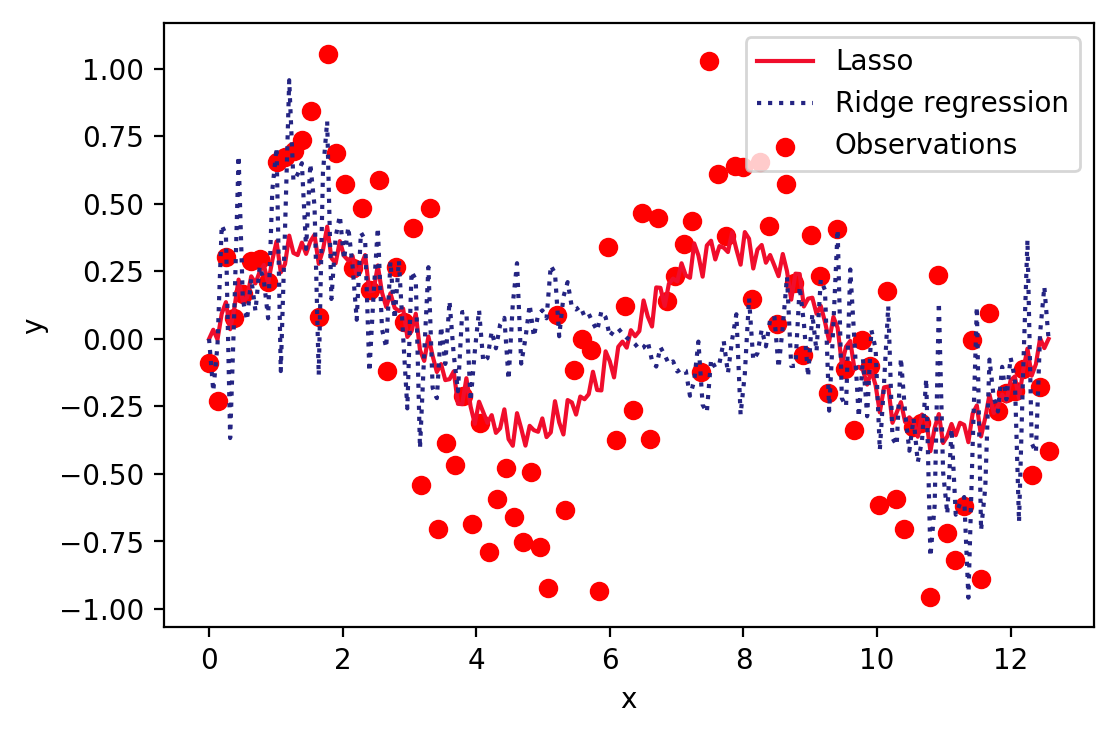

In [114]:
# Import the Lasso class from sklearn.linear_model
from sklearn.linear_model import Lasso

# 1. Form the design matrix.
NUM_BASIS = 100
Phi = form_fourier_design_matrix(x_data, NUM_BASIS)

# Perform the Lasso fit
lasso_model = Lasso(alpha = 0.1, max_iter = 10000, fit_intercept=False)
lasso_model.fit(Phi, y_data)

# Get the Lasso parameters
theta_lasso =  lasso_model.coef_

# Do the same for ridge regression solution for comparison
ridge_model = Ridge(alpha = 0.1, fit_intercept=False)
ridge_model.fit(Phi, y_data)
theta_ridge = ridge_model.coef_

# Apply models by predicting the y values for the refined set of x values in x_plot
Phi_plot = form_fourier_design_matrix(x_plot, NUM_BASIS)

# Multiply design matrix by the thetas found in both lasso and ridge regression
y_lasso = Phi_plot @ theta_lasso
y_ridge = Phi_plot @ theta_ridge

# Plot 
plt.plot(x_plot, y_lasso)
plt.plot(x_plot, y_ridge, ls=':')
plt.scatter(x_data, y_data, color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Lasso', 'Ridge regression', 'Observations'])

Not great, but let's see if we can identify which $sin(jx)$ contributed to the signal. To do that, we'll plot the $\theta$ values.

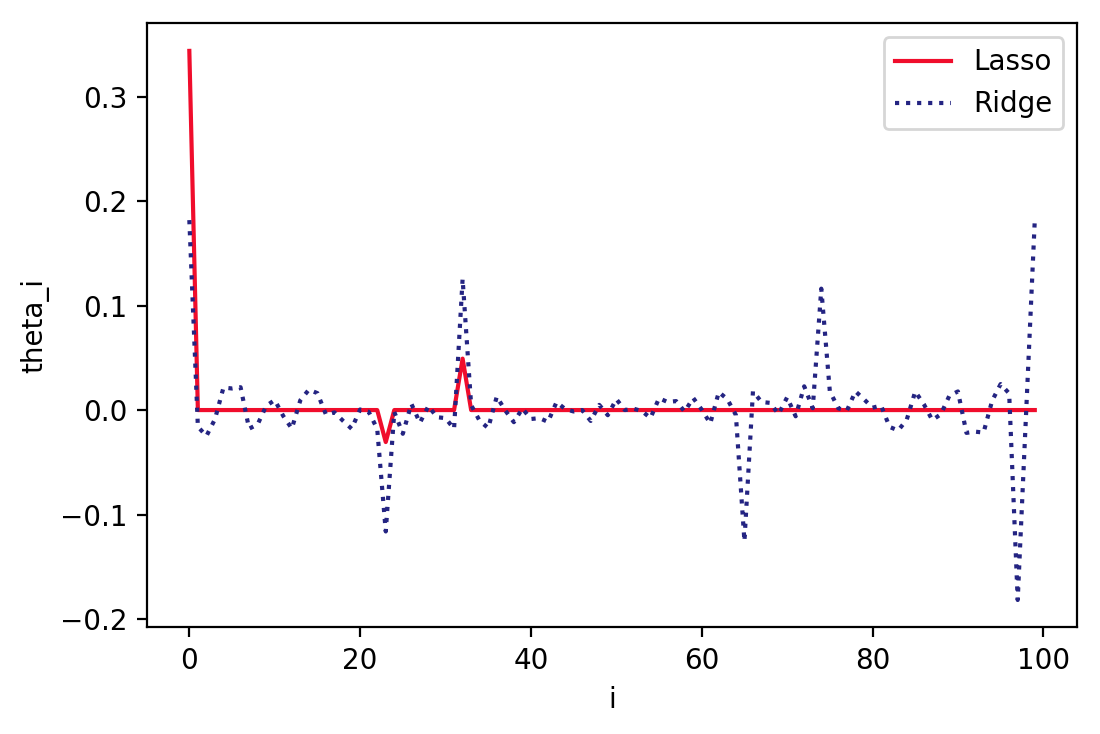

In [115]:
plt.plot(theta_lasso)
plt.plot(theta_ridge, ls=':')

plt.xlabel('i')
plt.ylabel('theta_i')
plt.legend(['Lasso', 'Ridge'])

We see that the Lasso estimate for the $\theta$ is quite sparse. Only about 5 out of 100 entries are non-zero. Remember, a relatively large non-zero value of $\theta_j$ says that the regression believes $\sin(jx)$ contributes to the signal (the observations). It doesn't appear that we're picking the correct $\sin$ functions, which were:

$$\left\{\sin(x), \sin(33x), \sin(75x) \right\}.$$

Maybe we didn't pick the $\lambda$ correctly. Let's use the `LassoCV` to pick the best $\lambda$ using cross validation.

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


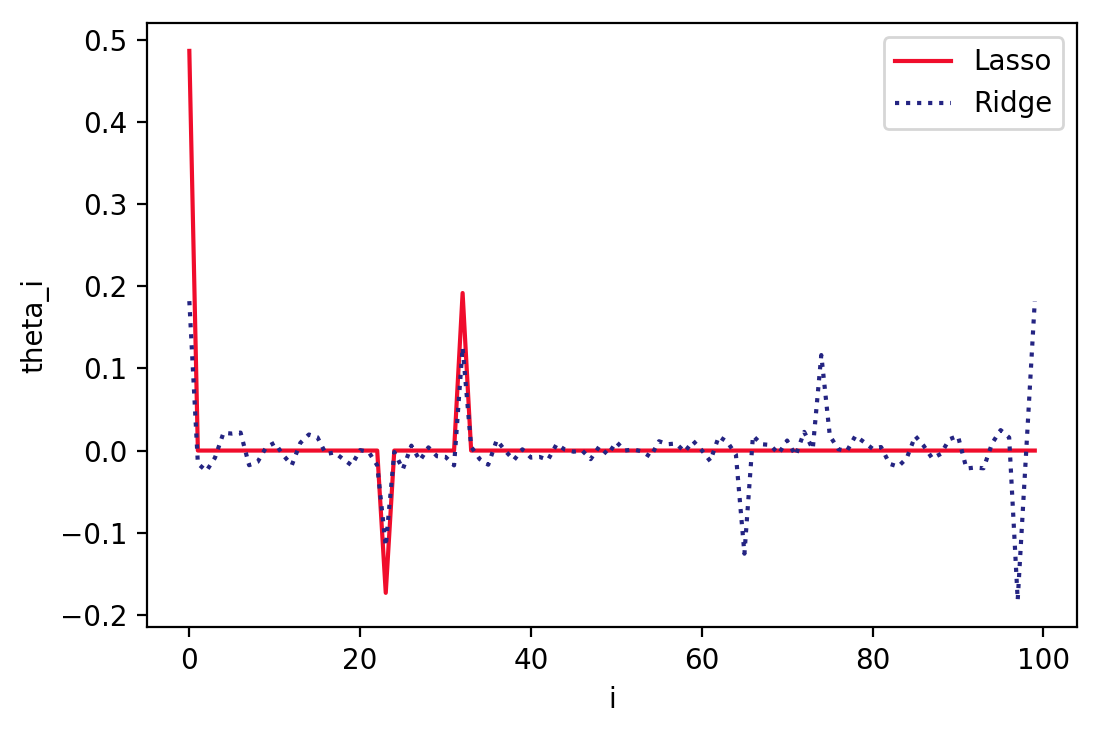

In [116]:
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(alphas = np.logspace(-3, 3))
lasso_model.fit(Phi, y_data)
theta_lasso =  lasso_model.coef_

y_lasso = Phi_plot @ theta_lasso

plt.plot(theta_lasso)
plt.plot(theta_ridge, ls=':')

plt.xlabel('i')
plt.ylabel('theta_i')
plt.legend(['Lasso', 'Ridge'])

Still not a great fit, and in reality, without extra information, this is perhaps the best we can hope to do. One extra piece of information, which is very common, is that we could assume that the $\theta$ values are all positive, which we can force the `LassoCV` class to do by passing in the `positive = True` argument.

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


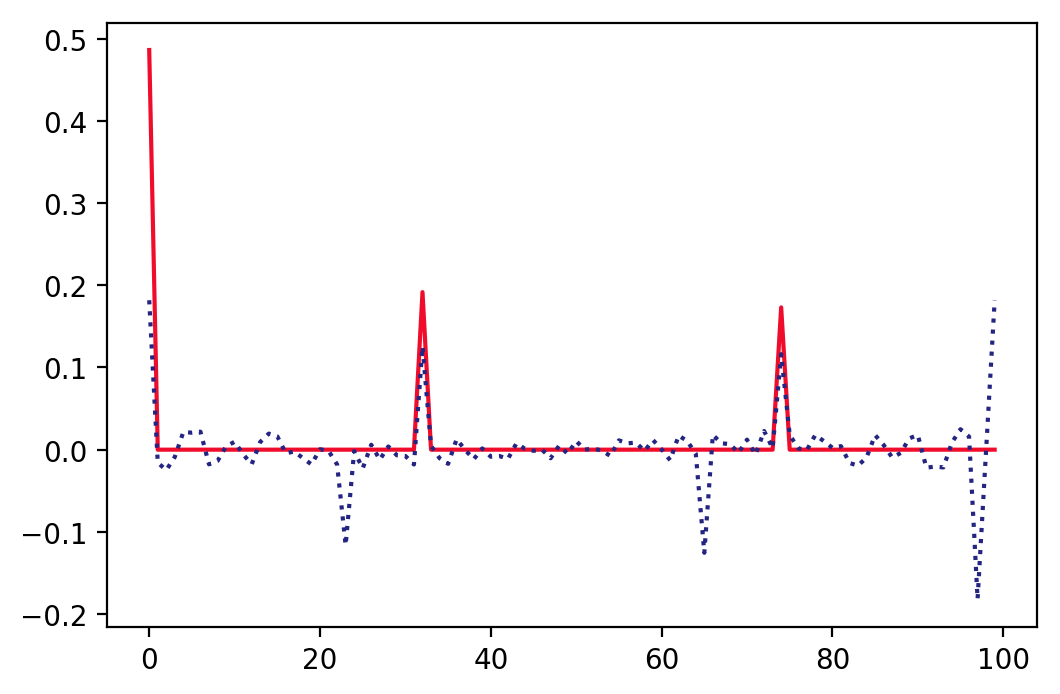

In [117]:
lasso_model = LassoCV(alphas = np.logspace(-3, 3), positive = True)
lasso_model.fit(Phi, y_data)
theta_lasso =  lasso_model.coef_

y_lasso = Phi_plot @ theta_lasso
y_ridge = Phi_plot @ theta_ridge

plt.plot(theta_lasso)
plt.plot(theta_ridge, ls=':')

We see that doing yields good results. Recall the original function was
$$    y =  0.5\sin(x) + 0.2\sin(33x) + 0.2\sin(75x) $$
which as 3 modes at 1, 33, and 75. The three largest coefficient values in the Lasso estimate correspond exactly to the true $\sin(jx)$ functions. The Lasso solution also predicts the presense of other function in the signal as well, but the magnitude of the corrsponding $\theta$ values aren't as large.

In [118]:
# Which modes?
np.where(theta_lasso > 0.1)

(array([ 0, 32, 74]),)